# 深層学習スクラッチ　畳み込みニューラルネットワーク

In [116]:
#基本ライブラリ
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

#データセット
#from sklearn.datasets import load_iris

In [117]:
#MNISTデータセット
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#平滑化
X_train_f = X_train.reshape(-1, 784)
X_test_f = X_test.reshape(-1, 784)

#前処理
X_train_ff = X_train_f.astype(np.float)
X_test_ff = X_test_f.astype(np.float)
X_train_ff /= 255
X_test_ff /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

Xt_train, Xt_val, yt_train, yt_val = train_test_split(X_train_ff, y_train_one_hot, test_size=0.2)
print(Xt_train.shape) # (48000, 784)
print(Xt_val.shape) # (12000, 784)
print(yt_train.shape)
print(yt_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


# 【問題2】1次元畳み込み後の出力サイズの計算

In [121]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
a = np.array([0,0])

for i in range(0, len(x) - len(w) + 1):
    a[i] = np.sum(x[i: i+len(w)]*w)+b
print(a)

[35 50]


In [122]:
def N_out(N_in, P, F, S):
    return (N_in + 2*P - F) / S + 1

P = 0
F = len(w)
S = 1

print(N_out(len(x), P, F, S))

2.0


# 【問題3】小さな配列での1次元畳み込み層の実験

In [124]:
y = np.array([45, 70])
da = y - a
print(da)

[10 20]


In [126]:
db = np.sum(da)
print("バイアスの傾き:", db)

バイアスの傾き: 30


In [127]:
dw = np.zeros(3)
for i in range(2):
    dw += x[i : i + len(w)] * da[i]
print("フィルタの傾き", dw)

フィルタの傾き [ 50.  80. 110.]


In [128]:
dx = np.zeros(len(x))
for i in range(2):
    dx[i : i + len(w)] += da[i] * w
print("xの傾き:", dx)

xの傾き: [ 30. 110. 170. 140.]


# 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [129]:
class SimpleConv1d:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """

    def __init__(self, initializer, optimizer, pad=0, fsize=0, stride=1):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.pad = pad
        self.fsize = fsize
        self.stride = stride
        self.W = initializer.W(fsize)
        self.B = 0

    def forward(self, X, w, b, init=False):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        if init:
            self.X = X
            self.W = w
            self.B = b
            self.LW = np.zeros(len(self.W))
            self.LX = np.zeros(len(X))
            self.A = np.zeros(int(N_out(len(X), self.pad, self.fsize, self.stride)))

        for i in range(0, len(X) - len(self.W) + 1):
            self.A[i] = np.sum(X[i : i + len(self.W)] * self.W) + self.B

        return self.A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.LB = np.sum(dA)

        for i in range(len(dA)):
            self.LW += self.X[i : i + len(self.W)] * dA[i]

        for i in range(2):
            self.LX[i : i + len(self.W)] += dA[i] * self.W

        LX = self.LX
        # 更新
        self = self.optimizer.update(self)
        # FC2 = FC2.optimizer.updata(FC2)
        # FC2 = SGD().update(FC2)

        return LX

    def N_out(N_in, P, F, S):
        return (N_in + 2 * P - F) / S + 1

In [134]:
test = SimpleConv1d(zabi(), SGD(), pad=0, fsize=3, stride=1)

x = np.array([1.0,2.0,3.0,4.0])
w = np.array([3.0, 5.0, 7.0])
b = np.array([1.0])

A = test.forward(x, w, b, init=True)
print("A:", A)

dZ = test.backward(da)
print("dZ:", dZ)
print("dW:", test.LW)
print("dB:",  test.LB)

A: [35. 50.]
dZ: [ 30. 110. 170. 140.]
dW: [ 50.  80. 110.]
dB: 30


In [131]:
class zabi():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, w, input_channel=1, output_channel=1 ):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.ones((output_channel, input_channel, w))

        return W
    
    def B(self, output_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.arange(1, output_channel + 1) .astype(float)
        
        return B

In [138]:
#ザビエル for Conv
class XavierlInit():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, w, input_channel=1, output_channel=1 ):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        xavier = 1 / np.sqrt(w)
        W = xavier * np.random.randn((output_channel, input_channel, w))

        return W
    
    def B(self, output_channel):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, output_channel) 
        
        return B

#ザビエル for NN
class XavierInitializer():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        xavier = 1 / np.sqrt(n_nodes1)
        W = xavier * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B

In [139]:
class HeInitializer():
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        he = np.sqrt( 2 / n_nodes1 )
        W = he * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2) 
        
        return B

In [140]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.LW
        layer.B -= self.lr*layer.LB

#AdaGrad for NN
class AdaGrad():
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hw = 0
        self.hb = 0
        self.hw_mean=[]
        self.hb_mean=[]
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.hw += (layer.LW)**2 
        self.hb +=  (layer.LB)**2
        self.hw_mean.append(np.mean(self.hw))
        self.hb_mean.append(np.mean(self.hb))
        
        layer.W -= self.lr / np.sqrt(self.hw + 1e-7) * layer.LW
        layer.B -= self.lr / np.sqrt(self.hb + 1e-7) * layer.LB

# 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [141]:
class relu:
    def __init__(self):
        self.mask = None

    def forward(self, X):
        self.mask = X <= 0
        self.mask = self.mask.reshape(1, -1)
        return np.maximum(0, X)

    def backward(self, LZ, A):
        LZ[self.mask] = 0
        dx = LZ
        return dx


class Tanh:
    """
    ハイパボリックタンジェント関数
    """

    def forward(self, X):
        return np.tanh(X)

    def backward(self, LZ, A):
        return LZ * (1 - np.tanh(A) ** 2)


class Softmax:
    """
    ソフトマックス関数
    """

    def forward(self, X):
        c = np.max(X, axis=1)
        exp_x = np.exp(X - c.reshape(-1, 1))  # オーバーフロー対策
        sum_exp_x = np.sum(exp_x, axis=1)
        y = exp_x / sum_exp_x.reshape(-1, 1)

        return y

    def backward(self, X):
        print("Softmax backward isn't made yet")
        pass


class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, def_name=None):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        XW = np.dot(X, self.W)
        self.A = XW + self.B

        return self.A

    def backward(self, dA, Z, FC_num):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        if FC_num == 0:
            self.LB = np.sum(dA, axis=0)
            self.LW = np.dot(Z.T, self.LA)
            dZ = np.dot(self.LA, self.W.T)
        else:
            self.LB = np.sum(dA, axis=0)
            self.LW = np.dot(Z.T, self.LA)
            dZ = np.dot(self.LA, self.W.T)

        # 更新
        self = self.optimizer.update(self)
        # FC2 = FC2.optimizer.updata(FC2)
        # FC2 = SGD().update(FC2)

        return dZ


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """

    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [142]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(
        self,
        nodes_num_list,
        ac_list,
        initialize_list,
        opt_list,
        itr=1000,
        verbose=True,
        lr=0.00001,
        sigma=0.01,
        b_size=20,
    ):
        self.verbose = verbose
        self.itr = itr
        self.lr = lr  # 学習率
        self.sigma = sigma  # ガウス分布の標準偏差
        self.b_size = b_size
        self.L = []
        self.FC = {}  # 各レイヤー格納辞書
        self.network = len(nodes_num_list)
        self.n_nodes = {i: nodes_num_list[i] for i in range(self.network)}
        self.activation = {i: ac_list[i] for i in range(self.network)}
        self.initialize_list = initialize_list
        for i in range(len(self.initialize_list)):
            self.initialize_list[i].sigma = self.sigma
        self.opt_list = opt_list
        for i in range(len(self.opt_list)):
            self.opt_list[i].lr = self.lr

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # 各レイヤーインスタンス化
        Z, LZ = [], []
        for i in range(self.network):
            if i == 0:
                self.FC[i] = FC(
                    X.shape[1],
                    self.n_nodes[i],
                    self.initialize_list[i],
                    self.opt_list[i],
                )
            else:
                self.FC[i] = FC(
                    self.n_nodes[i - 1],
                    self.n_nodes[i],
                    self.initialize_list[i],
                    self.opt_list[i],
                )
            Z.append(np.array([]))
            LZ.append(np.array([]))

        # エポック
        itr_count = 0
        for _ in range(self.itr):
            if itr_count % 10 == 0:
                print(itr_count, ">", end="")
            Lbatch = np.array([])

            get_mini_batch = GetMiniBatch(X, y, batch_size=self.b_size)
            for mini_X_train, mini_y_train in get_mini_batch:

                """フォワード
                """
                for i in range(self.network):
                    if i == 0:
                        A = self.FC[i].forward(mini_X_train)
                        Z[i] = self.activation[i].forward(A)
                    else:
                        A = self.FC[i].forward(Z[i - 1])
                        Z[i] = self.activation[i].forward(A)

                """バックプロパゲーション
                """
                for i in range(self.network)[::-1]:
                    if i == self.network - 1:  # 出力層
                        self.FC[i].LA = Z[i] - mini_y_train
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i - 1], i)
                    elif i == 0:  # 入力層
                        self.FC[i].LA = self.activation[i].backward(
                            LZ[i + 1], self.FC[i].A
                        )
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, mini_X_train, i)
                    else:  # 隠れ層
                        self.FC[i].LA = self.activation[i].backward(
                            LZ[i + 1], self.FC[i].A
                        )
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i - 1], i)

                """損失関数
                """
                Ltmp = 0
                for i in range(self.b_size):
                    Ltmp += np.sum(mini_y_train[i] * np.log(Z[-1][i]))
                Lbatch = np.append(Lbatch, (Ltmp / self.b_size) * -1)

            self.L.append(Lbatch.mean())
            itr_count += 1
            # print("---end of epoc---")

        if self.verbose:
            # verboseをTrueにした際は学習過程などを出力する
            print()
        pass

    def predict(self, Xt):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pZ = []
        for i in range(self.network):
            pZ.append(np.array([]))

        for i in range(self.network):
            if i == 0:
                A = self.FC[i].forward(Xt)
                pZ[i] = self.activation[i].forward(A)
            else:
                A = self.FC[i].forward(pZ[i - 1])
                pZ[i] = self.activation[i].forward(A)

        return pZ[-1]

In [144]:
nodes_num_list = [100, 400, 200, 100, 10]
ac_list = [relu(), relu(), relu(), relu(), Softmax()]
initialize_list = [
    HeInitializer(),
    HeInitializer(),
    HeInitializer(),
    HeInitializer(),
    XavierInitializer(),
]
opt_list = [AdaGrad(), AdaGrad(), AdaGrad(), AdaGrad(), AdaGrad()]

SDNN = ScratchDeepNeuralNetrowkClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=20, b_size=100, lr=0.01
)

In [ ]:
SDNN.fit(Xt_train, yt_train)
plt.plot(SDNN.L)

# 【問題8】学習と推定

In [ ]:
隠れ層２層の内、前１層をConvに

In [146]:
class NN_Conv1d:
    
    def __init__(self, initializer, optimizer, fsize, in_channel=1, out_channel=1, pad=0, stride=1):
        self.optimizer = optimizer
        self.initializer = initializer
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.pad = pad
        self.fsize = fsize   #1次元
        self.stride = stride
        self.B = 0
    
    def init(self, X):
        """
        Xは二次元を想定
        """
        self.X = self.pad_init(X, self.pad)
        self.W =  self.initializer.W(1, self.fsize)
        self.B = self.initializer.B(1)
        self.LB = np.zeros(self.B.shape)
        self.LW = np.zeros(self.W.shape)
        self.dZ = np.zeros(self.X.shape)
        self.A = np.zeros((X.shape[0], int(self.N_out(X.shape[1], self.pad, self.fsize, self.stride))))
        self.LA = np.copy(self.A)

    def forward(self, X, index):
        """
        Xは１次元を想定
        """
        for i in range(0, len(X) - self.W.shape[1] + 1):
            self.A[index, i] = np.sum(X[i: i+self.W.shape[1]] * self.W)+self.B        
        
        return self.A[index]
    
    def backward(self, dA, index):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.LB = np.sum(dA)
        
        for i in range(len(dA)):
            self.LW += (self.X[index, i: i+self.W.shape[1]] * dA[i])
        
        for i in range(len(dA)):
            self.dZ[index, i: i + self.W.shape[1]] += dA[i]*self.W.flatten()
        
        dZ = self.dZ
        
        self = self.optimizer.update(self, index)

        
        return dZ
    
    def N_out(self, N_in, P, F, S):
        return (N_in + 2*P - F) / S + 1

    def pad_init(self, X, pad):
        """
        １次元方向にパディングを追加する関数
        """
        for i in range(pad):
            X = np.insert(X, 0, 0, axis=1)
            X = np.insert(X, X.shape[1], 0, axis=1)
        
        return X

class NN_SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer, index):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.LW
        layer.B -= self.lr*layer.LB
    

In [150]:
class Scratch1dCNNClassifier:
    """
    多層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(
        self,
        nodes_num_list,
        ac_list,
        initialize_list,
        opt_list,
        itr=1000,
        verbose=True,
        lr=0.00001,
        sigma=0.01,
        b_size=20,
    ):
        self.verbose = verbose
        self.itr = itr
        self.lr = lr  # 学習率
        self.sigma = sigma  # ガウス分布の標準偏差
        self.b_size = b_size
        self.L = []
        self.FC = {}  # 各レイヤー格納辞書
        self.network = len(nodes_num_list)
        self.n_nodes = {i: nodes_num_list[i] for i in range(self.network)}
        self.activation = {i: ac_list[i] for i in range(self.network)}
        self.initialize_list = initialize_list
        for i in range(len(self.initialize_list)):
            self.initialize_list[i].sigma = self.sigma
        self.opt_list = opt_list
        for i in range(len(self.opt_list)):
            self.opt_list[i].lr = self.lr

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # 各レイヤーインスタンス化
        Z, LZ = [], []
        for i in range(self.network):
            if i == 0:
                self.FC[i] = NN_Conv1d(
                    self.initialize_list[i],
                    self.opt_list[i],
                    fsize=385,
                    in_channel=1,
                    out_channel=1,
                    pad=0,
                )
            else:
                self.FC[i] = FC(
                    self.n_nodes[i - 1],
                    self.n_nodes[i],
                    self.initialize_list[i],
                    self.opt_list[i],
                )
            Z.append(np.array([]))
            LZ.append(np.array([]))

        # エポック
        itr_count = 0
        self.FC[0].init(X)
        for _ in range(self.itr):
            if itr_count % 2 == 0:
                print(itr_count, ">>>>>>", end="")
            Lbatch = np.array([])
            index = 0

            for mini_X_train, mini_y_train in zip(X, y):

                """フォワード
                """
                for i in range(self.network):
                    if i == 0:
                        A = self.FC[i].forward(mini_X_train, index)
                        Z[i] = self.activation[i].forward(A).reshape(1, 400)

                    else:
                        A = self.FC[i].forward(Z[i - 1])
                        Z[i] = self.activation[i].forward(A)

                """バックプロパゲーション
                """
                for i in range(self.network)[::-1]:
                    if i == self.network - 1:  # 出力層
                        self.FC[i].LA = Z[i] - mini_y_train
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i - 1], i)
                    elif i == 0:  # Conv層
                        self.FC[i].LA[index] = self.activation[i].backward(
                            LZ[i + 1], self.FC[i].A[index]
                        )
                        LZ[i] = self.FC[i].backward(self.FC[i].LA[index], index)
                    else:  # 隠れ層
                        self.FC[i].LA = self.activation[i].backward(
                            LZ[i + 1], self.FC[i].A
                        )
                        LZ[i] = self.FC[i].backward(self.FC[i].LA, Z[i - 1], i)

                """損失関数
                """
                Ltmp = 0
                for i in range(self.b_size):
                    Ltmp += np.sum(mini_y_train[i] * np.log(Z[-1][i]))
                Lbatch = np.append(Lbatch, (Ltmp / self.b_size) * -1)
                index += 1

            self.L.append(Lbatch.mean())
            itr_count += 1
            # print("---end of epoc---")

        if self.verbose:
            # verboseをTrueにした際は学習過程などを出力する
            print()
        pass

    def predict(self, Xt):
        """
       ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pZ = []
        for i in range(self.network):
            pZ.append(np.array([]))

        index = 0
        for mini_X in Xt:
            for i in range(self.network):
                if i == 0:
                    A = self.FC[i].forward(Xt, index)
                    pZ[i] = self.activation[i].forward(A).reshape(1, 400)
                elif i == 2:
                    A = self.FC[i].forward(pZ[i - 1])
                    pZ[i] = np.append(pZ[i], self.activation[i].forward(A))
                else:
                    A = self.FC[i].forward(pZ[i - 1])
                    pZ[i] = self.activation[i].forward(A)

            index += 1

        return pZ[-1]

0 >>>>>>2 >>>>>>4 >>>>>>


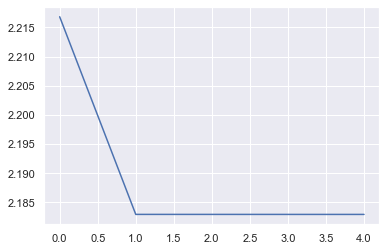

In [151]:
Xt_train1d = Xt_train[0:5000]
yt_train1d = yt_train[0:5000]

nodes_num_list = [400, 200, 10]
ac_list = [relu(), relu(), Softmax()]
initialize_list = [XavierInitializer(), HeInitializer(), XavierInitializer()]
opt_list = [NN_SGD(), AdaGrad(), AdaGrad()]

CNN = Scratch1dCNNClassifier(
    nodes_num_list, ac_list, initialize_list, opt_list, itr=5, b_size=1, lr=0.0001
)
CNN.fit(Xt_train1d, yt_train1d)
plt.plot(CNN.L)

In [152]:
CNN.L

[2.216816818759459,
 2.182934242593131,
 2.182932249494254,
 2.182930709177787,
 2.182929429623384]

In [3]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [4]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])


(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [6]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

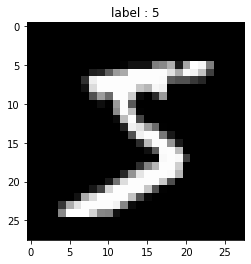

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
#X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [8]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [11]:
class SimpleConv1d:
    def __init__(self, weight, bias):
        self.weight = weight
        self.bias = bias
        
        
    def forward(self, x):#X入ってくる
        self.x = x
        predict = np.zeros([self.x.shape[0]-2, self.weight.shape[0]])
        
        roop = self.x.shape[0]-self.weight.shape[0] + 1

        index = np.arange(self.weight.shape[0])
        
        self.predict_list = []
        
        for i in range(roop):
            
            predict = int(np.dot(self.x[index + i],self.weight) + self.bias)
            self.predict_list.append(predict)
            
        return self.predict_list
    
    def backward(self,x):
        delta_a = np.array([10, 20]) #誤差
        delta_B = np.sum(self.predict_list)
        self.delta_W_list =[]# np.zeros(self.weight)
        
        self.delta_W0_list = self.weight.tolist()
        self.delta_W0_list.append(0)
        self.delta_W0_list.insert(0, 0)
        self.delta_X_list = []
        
        #delta_W
        for j in range(self.weight.shape[0]):
            delta_W =  (delta_a[0]*self.x[j]) +   (delta_a[1]*self.x[j + 1]) 
            print(delta_W)
            self.delta_W_list.append(delta_W)
            
        #delta_X
        for k in range(self.x.shape[0]):
            delta_X = (delta_a[0]*self.delta_W0_list[k+1]) +   (delta_a[1]*self.delta_W0_list[k])
            self.delta_X_list.append(delta_X)
        return self.delta_X_list
        
        
    

In [12]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

イニシャライザー

In [13]:
# Xavierをインスタンス化するときはXavier(self.n_nodes)とする

class Xavier:
    def __init__(self, n_nodes1):
        self.n_nodes1= n_nodes1
        self.sigma = 1/np.sqrt(self.n_nodes1)
               
    def W(self, n_nodes1): #フィルタ
        return self.sigma*np.random.randn(n_nodes1)
    
    def B(self, n_nodes2): #1?
        return  self.sigma * np.random.randn(n_nodes2)

In [14]:
XXX = Xavier(4)

In [15]:
XXX.W(3)

array([-0.22305639, -0.31210672,  0.2333637 ])

In [44]:
class SimpleConv1d:
 
     def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # 初期化
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1)#?
        self.B =  initializer.B(n_nodes2)#?
        pass
        
    def forward(self, Z):
        self.Z = Z.copy()
        return np.dot(Z, self.W) + self.B #output=A
        


    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dB = dA #b3grad = delta1=dA
        #print(self.Z.shape)
        #print(dA.shape)
        self.dW = np.dot(self.Z.T,dA) #np.dot(___Z2___, dA)shapedW?? = np.dot(self.Z,dA) のshape確認
        
        dZ = np.dot(dA, self.W.T)#(np.dot(delta1,self.W3.T)
        
        # 更新
        self = self.optimizer.update(self) #??????
        return dZ
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

In [18]:
class ScrachDeepNeuralNetworkRegressor():
    
    def __init__(self, n_epochs, batch, alpha = np.exp(-7), sigma = 0.01, n_nodes1 = 400, n_nodes2 = 200, n_output = 10):
        self.n_epochs = n_epochs
        self.batch = batch
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.loss = []#np.zeros(n_epochs)
        self.val_loss = []#np.zeros(n_epochs)
        self.alpha = alpha
        self.sigma = sigma
        
    def fit(self, X, y, X_val=None, y_val=None, val=False):

        self.X = X
        self.y = y
        self.n_features = self.X.shape[1]
        train_minibatch = GetMiniBatch(self.X, y, self.batch)
        test_minibatch = GetMiniBatch(X_val, y_val, self.batch)
        
        optimizer = SGD(self.alpha)
        #optimizer1 = AdaGrad(self.alpha)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        #self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer1)
        #self.activation1 = Tanh()
        self.activation1 = ReLU()
        #optimizer2 = AdaGrad(self.alpha)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        #self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer2)
        #self.activation2 = Tanh()
        self.activation2 = ReLU()
        #optimizer3 = AdaGrad(self.alpha)
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        #self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer3)
        self.activation3 = Softmax_with_crossentropyloss()
        
        for epoch in range(self.n_epochs):
            for mini_X, mini_y in train_minibatch:
                X = mini_X
                y = mini_y#[:,np.newaxis] ############
                #フォワード
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1) #Tanh().forward()
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                #バックワード
                dA3 = self.activation3.backward(y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない



                
        return
            
                

In [19]:
def after_out(n_in, filter_size, stride, pad):
    n_in = n_in.shape[0]
    out = (n_in + 2*pad - filter_size)/stride + 1
    return out

In [20]:
n_in = np.random.randn(4)
n_in.shape[0]

4

In [21]:
af = after_out(n_in,3,1,0)
af

2.0

入力x、重みw、バイアスbを次のようにします。

In [22]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
a = np.zeros([2, 3])
b = np.array([1])
predict = np.zeros([x.shape[0]-2,w.shape[0]])


In [23]:
test = SimpleConv1d(w, b)

In [24]:
yyy = test.forward(x)
yyy

[35, 50]

In [25]:
test.backward(x)

50
80
110


[30, 110, 170, 140]

In [26]:
print(w)
delta_W_list = np.zeros(len(w))
delta_W_list

[3 5 7]


array([0., 0., 0.])

In [27]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [28]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad= 0)
print(col1.shape)

(9, 75)


In [29]:
w_random = np.random.rand(2, 3, 3, 3)
w_random

array([[[[0.41149353, 0.31743926, 0.57216953],
         [0.63948939, 0.96565898, 0.87668382],
         [0.13853787, 0.98550537, 0.50329796]],

        [[0.00416114, 0.00853549, 0.09721422],
         [0.72830055, 0.21767349, 0.06555946],
         [0.53618484, 0.30941128, 0.30451651]],

        [[0.98371654, 0.38787934, 0.15032263],
         [0.24521961, 0.32417089, 0.43490609],
         [0.4446306 , 0.78062791, 0.74595924]]],


       [[[0.12540969, 0.46709371, 0.24766485],
         [0.40123331, 0.94784044, 0.61968127],
         [0.1837575 , 0.12612049, 0.52954342]],

        [[0.60468265, 0.12788636, 0.86863193],
         [0.92756783, 0.36762147, 0.26166019],
         [0.34761498, 0.28644808, 0.82355617]],

        [[0.12460774, 0.95175554, 0.13672596],
         [0.41164183, 0.01345122, 0.43901727],
         [0.32141284, 0.10460882, 0.6724505 ]]]])

In [30]:
w_random.reshape([2,-1])

array([[0.41149353, 0.31743926, 0.57216953, 0.63948939, 0.96565898,
        0.87668382, 0.13853787, 0.98550537, 0.50329796, 0.00416114,
        0.00853549, 0.09721422, 0.72830055, 0.21767349, 0.06555946,
        0.53618484, 0.30941128, 0.30451651, 0.98371654, 0.38787934,
        0.15032263, 0.24521961, 0.32417089, 0.43490609, 0.4446306 ,
        0.78062791, 0.74595924],
       [0.12540969, 0.46709371, 0.24766485, 0.40123331, 0.94784044,
        0.61968127, 0.1837575 , 0.12612049, 0.52954342, 0.60468265,
        0.12788636, 0.86863193, 0.92756783, 0.36762147, 0.26166019,
        0.34761498, 0.28644808, 0.82355617, 0.12460774, 0.95175554,
        0.13672596, 0.41164183, 0.01345122, 0.43901727, 0.32141284,
        0.10460882, 0.6724505 ]])